#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
path = '/content/drive/MyDrive/Colab_Notebooks/6th_mini_project_1/'

### **(2) 라이브러리 설치 및 불러오기**

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [152]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [153]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [154]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [155]:
# date, month, 요일, daily_qty, season, isWinter, 전일대비 oil 상승or하락, daily_방문고객수, 발주량(daily_qty의 2일 후)

## **(1) 상품 : 3 - Beverage**

In [156]:
df = pd.merge(sales, oil_price, how = 'left', on = 'Date')
df = pd.merge(df, orders, how = 'left', on = ['Date', 'Store_ID'])
df = pd.merge(df, stores, how = 'left', on = 'Store_ID')
df = pd.merge(df, products, how = 'left', on = 'Product_ID')

df

,Date,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,City,State,Store_Type,Product_Code,SubCategory,Category,LeadTime,Price
0,2014-01-01,1,0.000,3,NaN,NaN,Saint Paul,\tMinnesota,4,DB001,Beverage,Drink,2,8
1,2014-01-01,1,0.000,5,NaN,NaN,Saint Paul,\tMinnesota,4,FB001,BAKERY,Food,2,6
2,2014-01-01,1,0.000,7,NaN,NaN,Saint Paul,\tMinnesota,4,HC001,Cleaning,Household Goods,2,15
3,2014-01-01,1,0.000,8,NaN,NaN,Saint Paul,\tMinnesota,4,FM001,Yogurt,Food,2,4
4,2014-01-01,1,0.000,10,NaN,NaN,Saint Paul,\tMinnesota,4,GE001,EGGS,Grocery,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934270,2017-02-28,54,24.000,38,54.0,729.0,LA,\tCalifornia,3,DA001,Wine,Drink,2,12
934271,2017-02-28,54,49.222,24,54.0,729.0,LA,\tCalifornia,3,GM001,Meats,Grocery,3,17
934272,2017-02-28,54,12.000,27,54.0,729.0,LA,\tCalifornia,3,HH001,Home Appliances,Household Goods,2,150
934273,2017-02-28,54,59.000,29,54.0,729.0,LA,\tCalifornia,3,FP001,Prepared,Food,2,18


In [157]:
df_3 = df[(df['Product_ID']==3) & (df['Store_ID']==44)]
df_3

,Date,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,City,State,Store_Type,Product_Code,SubCategory,Category,LeadTime,Price
645,2014-01-01,44,0.0,3,NaN,NaN,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
1456,2014-01-02,44,9853.0,3,95.14,4422.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
2267,2014-01-03,44,8647.0,3,93.66,4167.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
3078,2014-01-04,44,15153.0,3,NaN,5341.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
3889,2014-01-05,44,15606.0,3,NaN,5123.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930865,2017-02-24,44,10208.0,3,53.99,4549.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
931676,2017-02-25,44,12361.0,3,NaN,4619.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
932487,2017-02-26,44,10108.0,3,NaN,3877.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
933298,2017-02-27,44,10006.0,3,54.04,3961.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8


In [158]:
drop_cols = ['Store_ID', 'Product_ID', 'City', 'State', 'Store_Type', 'Product_Code', 'SubCategory', 'Category']

In [159]:
df_3.drop(columns=drop_cols, axis=1, inplace=True)

In [160]:
df_3

,Date,Qty,WTI_Price,CustomerCount,LeadTime,Price
645,2014-01-01,0.0,NaN,NaN,2,8
1456,2014-01-02,9853.0,95.14,4422.0,2,8
2267,2014-01-03,8647.0,93.66,4167.0,2,8
3078,2014-01-04,15153.0,NaN,5341.0,2,8
3889,2014-01-05,15606.0,NaN,5123.0,2,8
...,...,...,...,...,...,...
930865,2017-02-24,10208.0,53.99,4549.0,2,8
931676,2017-02-25,12361.0,NaN,4619.0,2,8
932487,2017-02-26,10108.0,NaN,3877.0,2,8
933298,2017-02-27,10006.0,54.04,3961.0,2,8


In [161]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# 주말 여부 계산
df_3['Weekend'] = df_3['Date'].dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

# 공휴일 여부 계산
cal = calendar()
holidays = cal.holidays(start=df_3['Date'].min(), end=df_3['Date'].max())
df_3['Holiday'] = df_3['Date'].isin(holidays)

# Black Friday 여부 계산
# 추수감사절은 11월 넷째 목요일이므로, Black Friday는 그 다음날 금요일
# 추수감사절은 11월 넷째 목요일
def get_fourth_thursday_of_november(year):
    november_first = pd.Timestamp(year=year, month=11, day=1)
    fourth_thursday = (november_first + pd.offsets.Day((3 - november_first.weekday()) % 7)
                       + pd.offsets.Week(3))
    return fourth_thursday

df_3['B_Friday'] = df_3['Date'].apply(lambda x: x == get_fourth_thursday_of_november(x.year) + pd.Timedelta(days=1))


df_3['Total_sales'] = df_3['Qty'] * df_3['Price']

In [162]:
df_3['target'] = df_3['Qty'].shift(-2)
df_3.drop(columns=['LeadTime'], axis=1, inplace=True)

In [163]:
df_3 = df_3.reset_index(drop=True)

In [164]:
df_3

,Date,Qty,WTI_Price,CustomerCount,Price,Weekend,Holiday,B_Friday,Total_sales,target
0,2014-01-01,0.0,NaN,NaN,8,False,True,False,0.0,8647.0
1,2014-01-02,9853.0,95.14,4422.0,8,False,False,False,78824.0,15153.0
2,2014-01-03,8647.0,93.66,4167.0,8,False,False,False,69176.0,15606.0
3,2014-01-04,15153.0,NaN,5341.0,8,True,False,False,121224.0,7900.0
4,2014-01-05,15606.0,NaN,5123.0,8,True,False,False,124848.0,7188.0
...,...,...,...,...,...,...,...,...,...,...
1147,2017-02-24,10208.0,53.99,4549.0,8,False,False,False,81664.0,10108.0
1148,2017-02-25,12361.0,NaN,4619.0,8,True,False,False,98888.0,10006.0
1149,2017-02-26,10108.0,NaN,3877.0,8,True,False,False,80864.0,14374.0
1150,2017-02-27,10006.0,54.04,3961.0,8,False,False,False,80048.0,NaN


In [165]:
print(df_3['Weekend'].value_counts())
print(df_3['Holiday'].value_counts())
print(df_3['B_Friday'].value_counts())

Weekend
False    823
True     329
Name: count, dtype: int64
Holiday
False    1121
True       31
Name: count, dtype: int64
B_Friday
False    1149
True        3
Name: count, dtype: int64


In [166]:
df_3.isna().sum()

Date               0
Qty                0
WTI_Price        357
CustomerCount      6
Price              0
Weekend            0
Holiday            0
B_Friday           0
Total_sales        0
target             2
dtype: int64

In [167]:
# 'Qty'가 0.0인 경우 'CustomerCount'를 0.0으로 설정
df_3.loc[df_3['Qty'] == 0.0, 'CustomerCount'] = 0.0

In [168]:
df_3['CustomerCount'] = df_3['CustomerCount'].interpolate(method='linear')

In [169]:
df_3['WTI_Price'] = df_3['WTI_Price'].interpolate(method='linear')
df_3['WTI_Price'].fillna(method='bfill', inplace=True)

In [170]:
df_3.dropna(axis=0, inplace=True)

In [171]:
bool_columns = df_3.select_dtypes(include=['bool']).columns
df_3[bool_columns] = df_3[bool_columns].astype(int)

## **(2) 상품 : 12 - Milk**

In [172]:
df = pd.merge(sales, products, on='Product_ID')

In [173]:
df_12 = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 12)]

In [174]:
df_12

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
373291,2014-01-01,44,0.0,12,GA001,Milk,Food,2,6
373345,2014-01-02,44,9647.0,12,GA001,Milk,Food,2,6
373399,2014-01-03,44,8879.0,12,GA001,Milk,Food,2,6
373453,2014-01-04,44,14188.0,12,GA001,Milk,Food,2,6
373507,2014-01-05,44,14490.0,12,GA001,Milk,Food,2,6
...,...,...,...,...,...,...,...,...,...
435229,2017-02-24,44,10630.0,12,GA001,Milk,Food,2,6
435283,2017-02-25,44,12978.0,12,GA001,Milk,Food,2,6
435337,2017-02-26,44,10899.0,12,GA001,Milk,Food,2,6
435391,2017-02-27,44,10618.0,12,GA001,Milk,Food,2,6


In [175]:
state_df = pd.merge(df, stores, on='Store_ID')

In [176]:
state_df_milk = state_df[state_df['Product_ID'] == 12]

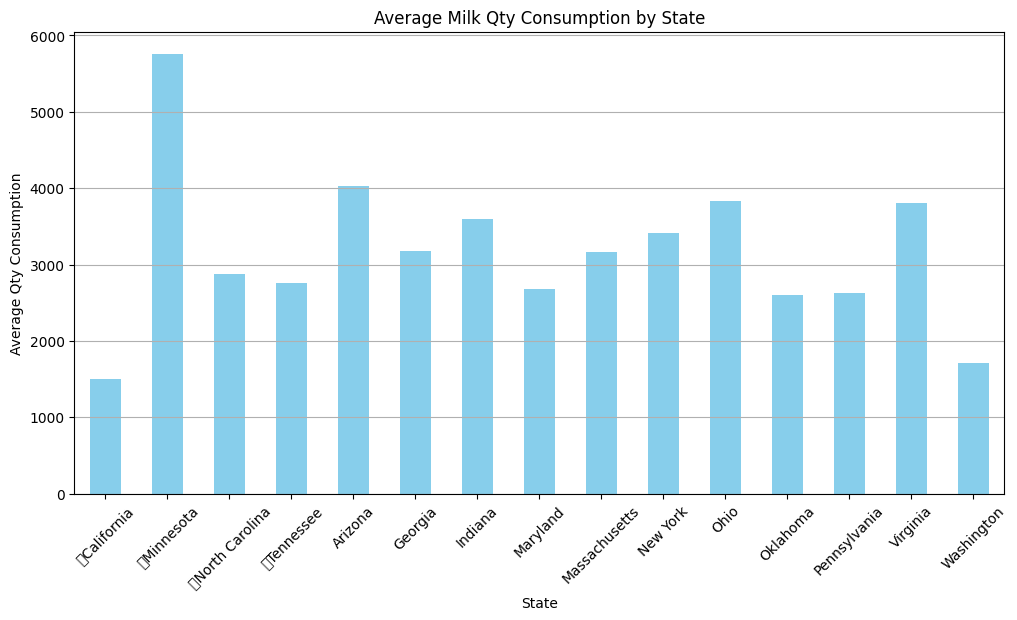

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
state_df_milk.groupby('State')['Qty'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Milk Qty Consumption by State')
plt.xlabel('State')
plt.ylabel('Average Qty Consumption')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [178]:
df_12_season = df_12.copy()

df_12_season['Season'] = df_12_season['Date'].dt.month.apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Autumn' if x in [9, 10, 11] else 'Winter')))

In [179]:
df_12_season

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Season
373291,2014-01-01,44,0.0,12,GA001,Milk,Food,2,6,Winter
373345,2014-01-02,44,9647.0,12,GA001,Milk,Food,2,6,Winter
373399,2014-01-03,44,8879.0,12,GA001,Milk,Food,2,6,Winter
373453,2014-01-04,44,14188.0,12,GA001,Milk,Food,2,6,Winter
373507,2014-01-05,44,14490.0,12,GA001,Milk,Food,2,6,Winter
...,...,...,...,...,...,...,...,...,...,...
435229,2017-02-24,44,10630.0,12,GA001,Milk,Food,2,6,Winter
435283,2017-02-25,44,12978.0,12,GA001,Milk,Food,2,6,Winter
435337,2017-02-26,44,10899.0,12,GA001,Milk,Food,2,6,Winter
435391,2017-02-27,44,10618.0,12,GA001,Milk,Food,2,6,Winter


In [180]:
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')

In [181]:
df_12_season_oil = pd.merge(df_12_season, oil_price, on='Date')

In [182]:
df_12_season_oil

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Season,WTI_Price
0,2014-01-01,44,0.0,12,GA001,Milk,Food,2,6,Winter,95.14
1,2014-01-02,44,9647.0,12,GA001,Milk,Food,2,6,Winter,95.14
2,2014-01-03,44,8879.0,12,GA001,Milk,Food,2,6,Winter,93.66
3,2014-01-06,44,7614.0,12,GA001,Milk,Food,2,6,Winter,93.12
4,2014-01-07,44,7124.0,12,GA001,Milk,Food,2,6,Winter,93.31
...,...,...,...,...,...,...,...,...,...,...,...
818,2017-02-22,44,8931.0,12,GA001,Milk,Food,2,6,Winter,53.61
819,2017-02-23,44,8643.0,12,GA001,Milk,Food,2,6,Winter,54.48
820,2017-02-24,44,10630.0,12,GA001,Milk,Food,2,6,Winter,53.99
821,2017-02-27,44,10618.0,12,GA001,Milk,Food,2,6,Winter,54.04


## **(3) 상품 : 42 - Agricultural products**

In [183]:
# Date
# Month
# Day_of_the_week (요일)
# Daily_Qty (일별 판매량)
# IsWinter (겨울 여부)
# IsSummer (여름 여부)
# WTI_Price_Change (휘발유 가격의 전일 대비 상승 또는 하락)
# Daily_CustomerCount (일별 방문 고객 수)
# # LeadTime_Qty (발주량, 일별 판매량의 2일 후 데이터)
# oil_price.isnull().sum()
# oil_price=oil_price.interpolate(method='linear',limit_direction='both')
# oil_price.isnull().sum()

In [184]:
# 44번매장의 42번 상품 데이터프레임
df_42=sales[(sales['Store_ID']==44)&(sales['Product_ID']==42)]

or44=orders[orders['Store_ID']==44]

# 오일 가격 결측치 선형보간
# oil_price=oil_price.interpolate(method='linear',limit_direction='both')

# 데이터 합치기
df_42=pd.merge(df_42,or44)
# df_42=pd.merge(df_42,oil_price)

# # # 전일대비 오일 가격비교 상승 1 하락 0
# # df_42['oil_updown'] = (df_42['WTI_Price'] > df_42['WTI_Price'].shift(1)).astype(int)
# oil_price['Price_Change'] = oil_price['WTI_Price'].diff()
# oil_price['WTI_Price_Change'] = pd.cut(oil_price['Price_Change'], bins=[-float('inf'), 0, 1, float('inf')], labels=['Down', 'Flat', 'Up'])
# oil_price['yesterday_price'] = oil_price['WTI_Price'].shift(1)

# # 수치 매핑을 위한 딕셔너리 생성
# change_mapping = {'Down': -1, 'Flat': 0, 'Up': 1}

# # 매핑 적용
# oil_price['oil_updown'] = oil_price['WTI_Price_Change'].map(change_mapping)
# df_42 = pd.merge(df_42, oil_price[['Date', 'oil_updown']], on='Date', how='left')
# df_42 = pd.merge(df_42, oil_price[['Date', 'yesterday_price']], on='Date', how='left')

df_42['Year']=df_42['Date'].dt.year
df_42['Month']=df_42['Date'].dt.month
df_42['Day']=df_42['Date'].dt.day
df_42['Day_of_week']=df_42['Date'].dt.weekday
df_42['Day_of_week_2']=df_42['Date'].dt.weekday.shift(-2)

df_42['isSummer'] = df_42['Month'].isin([6, 7, 8]).astype(int)
df_42['isWinter'] = df_42['Month'].isin([1, 2, 12]).astype(int)

#필요없는 컬럼 제거
df_42.drop(['Store_ID','Product_ID'],axis=1,inplace=True)

df_42['target'] = df_42['Qty'].shift(-2)
# 쉬프트하고 생긴 마지막 2개 결측치 행 제거
df_42 = df_42.iloc[:-2]

df_42

,Date,Qty,CustomerCount,Year,Month,Day,Day_of_week,Day_of_week_2,isSummer,isWinter,target
0,2014-01-02,76.0,4422,2014,1,2,3,5.0,0,1,78.0
1,2014-01-03,74.0,4167,2014,1,3,4,6.0,0,1,88.0
2,2014-01-04,78.0,5341,2014,1,4,5,0.0,0,1,65.0
3,2014-01-05,88.0,5123,2014,1,5,6,1.0,0,1,78.0
4,2014-01-06,65.0,3917,2014,1,6,0,2.0,0,1,73.0
...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,72.0,3834,2017,2,22,2,4.0,0,1,91.0
1140,2017-02-23,98.0,3955,2017,2,23,3,5.0,0,1,105.0
1141,2017-02-24,91.0,4549,2017,2,24,4,6.0,0,1,108.0
1142,2017-02-25,105.0,4619,2017,2,25,5,0.0,0,1,78.0


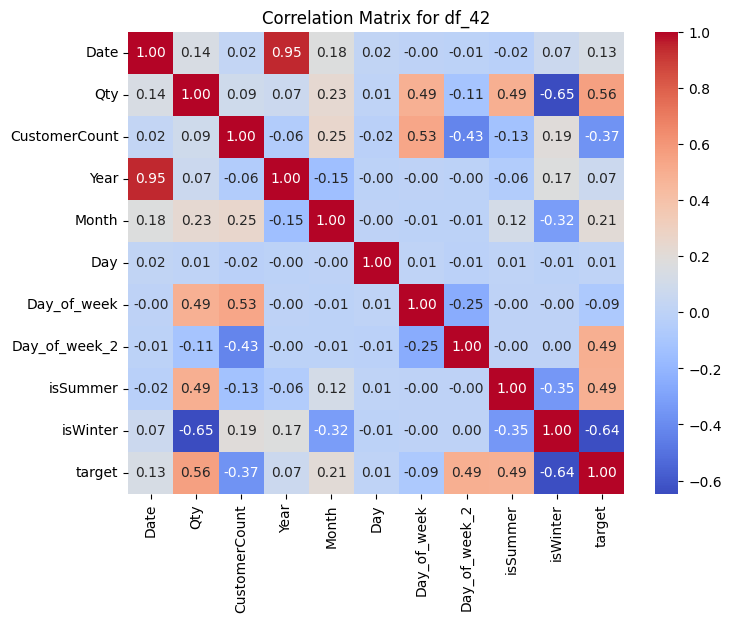

In [185]:

# 상관계수 계산
correlation_matrix = df_42.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for df_42')
plt.show()

In [186]:
print(df_42.shape, df_42.columns)

(1144, 11) Index(['Date', 'Qty', 'CustomerCount', 'Year', 'Month', 'Day', 'Day_of_week',
       'Day_of_week_2', 'isSummer', 'isWinter', 'target'],
      dtype='object')


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [187]:
target = 'target'

x = df_3.drop([target, 'Date'], axis =1)
y = df_3.loc[:, target]

In [188]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=60, shuffle=False)

In [189]:
scaler_x = MinMaxScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)

In [190]:
scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s = scaler_y.transform(y_val.values.reshape(-1,1))

### **2) 모델링**

In [191]:
nfeatures = x_train_s.shape[1]

clear_session()

model_DNN_3 = Sequential([Dense(50, input_shape = (nfeatures,), activation = 'relu'),
                          Dense(30, activation='relu'),
                          Dense(10, activation='relu'),
                    Dense(1)])

model_DNN_3.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

In [192]:
hist_DNN_3 = model_DNN_3.fit(x_train_s, y_train_s, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 2s 9ms/step - loss: 0.0747 - val_loss: 0.0307
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0256 - val_loss: 0.0248
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0172
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0143
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0137
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.0131
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0128
Epoch 9/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0127
Epoch 10/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0133
Epoch 11/50
28/28 [

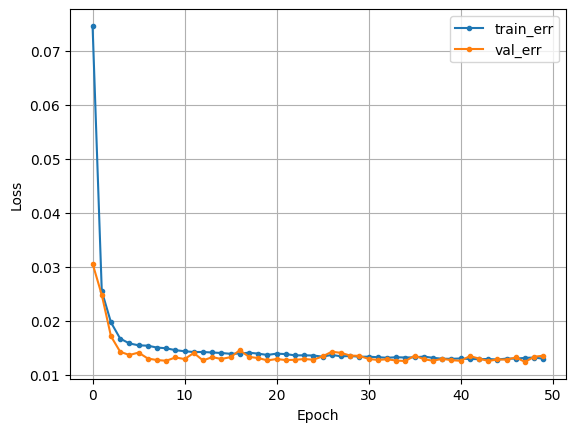

In [193]:
dl_history_plot(hist_DNN_3)

In [194]:
pred = model_DNN_3.predict(x_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 6ms/step


In [195]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 2970.33330078125
MAPE: 8.679002363927374e+17
R2  : -0.20096366843056956


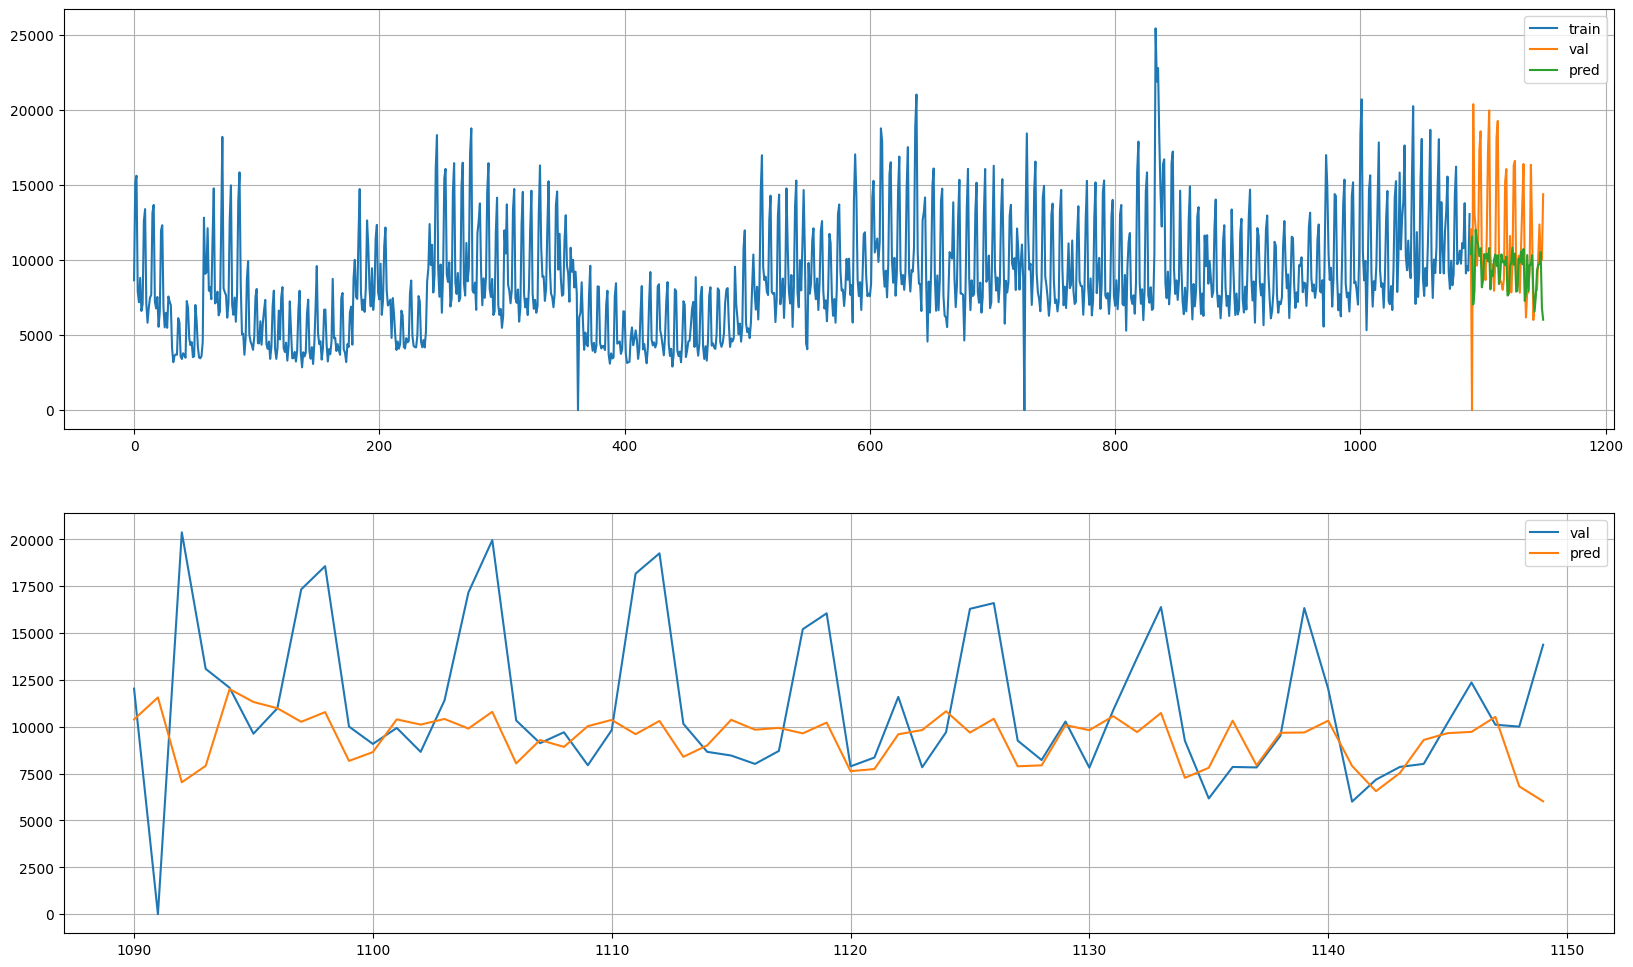

In [196]:
plot_model_result(y_train, y_val, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [197]:
df_12_season = df_12.copy()

df_12_season['Season'] = df_12_season['Date'].dt.month.apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Autumn' if x in [9, 10, 11] else 'Winter')))
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')
df_12_season_oil = pd.merge(df_12_season, oil_price, on='Date')
df_12_season_oil.drop(columns=['Product_ID', 'Store_ID', 'Product_Code', 'SubCategory', 'Category', 'LeadTime', 'Price'], inplace=True)

In [198]:
df_12_season_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       823 non-null    datetime64[ns]
 1   Qty        823 non-null    float64       
 2   Season     823 non-null    object        
 3   WTI_Price  823 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 25.8+ KB


In [199]:
df_12_season_oil_final = df_12_season_oil.copy()

df_12_season_oil_final['Year'] = df_12_season_oil_final['Date'].dt.year
df_12_season_oil_final['Month'] = df_12_season_oil_final['Date'].dt.month
df_12_season_oil_final['Day'] = df_12_season_oil_final['Date'].dt.day

df_12_season_oil_final_encoded = pd.get_dummies(df_12_season_oil_final['Season'])
df_12_season_oil_final = pd.concat([df_12_season_oil_final, df_12_season_oil_final_encoded], axis=1)
df_12_season_oil_final.drop(columns=['Season', 'Date'], inplace=True)

df_12_season_oil_final

,Qty,WTI_Price,Year,Month,Day,Autumn,Spring,Summer,Winter
0,0.0,95.14,2014,1,1,False,False,False,True
1,9647.0,95.14,2014,1,2,False,False,False,True
2,8879.0,93.66,2014,1,3,False,False,False,True
3,7614.0,93.12,2014,1,6,False,False,False,True
4,7124.0,93.31,2014,1,7,False,False,False,True
...,...,...,...,...,...,...,...,...,...
818,8931.0,53.61,2017,2,22,False,False,False,True
819,8643.0,54.48,2017,2,23,False,False,False,True
820,10630.0,53.99,2017,2,24,False,False,False,True
821,10618.0,54.04,2017,2,27,False,False,False,True


In [200]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_12_season_oil_final[['Year', 'Month', 'Day', 'Winter', 'Spring', 'Summer', 'Autumn', 'WTI_Price', 'Qty']])

In [201]:
val_size = 60
train_size = len(scaled_data) - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:]

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]

### **2) 모델링**

In [202]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense

model_12 = Sequential()
model_12.add(Dense(1, input_dim=X_train.shape[1], activation='linear'))

model_12.compile(loss='mean_squared_error', optimizer='adam')

history_12 = model_12.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=0)

In [203]:
y_pred = model_12.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R2 Score:", r2)

2/2 [==============================] - 0s 8ms/step
Mean Squared Error (MSE): 0.02784130866534632
Mean Absolute Percentage Error (MAPE): 44.91715230427217
R2 Score: -2.797518447044829


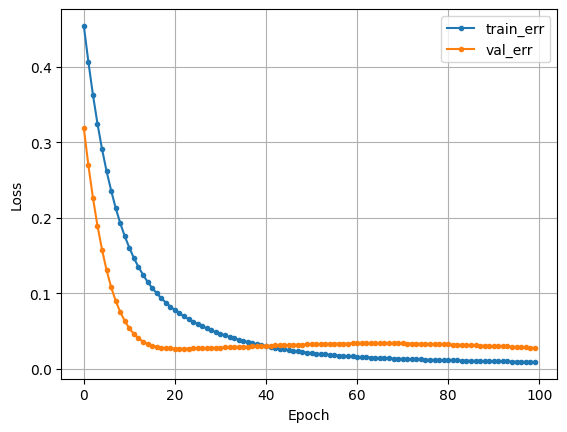

In [204]:
dl_history_plot(history_12.history)

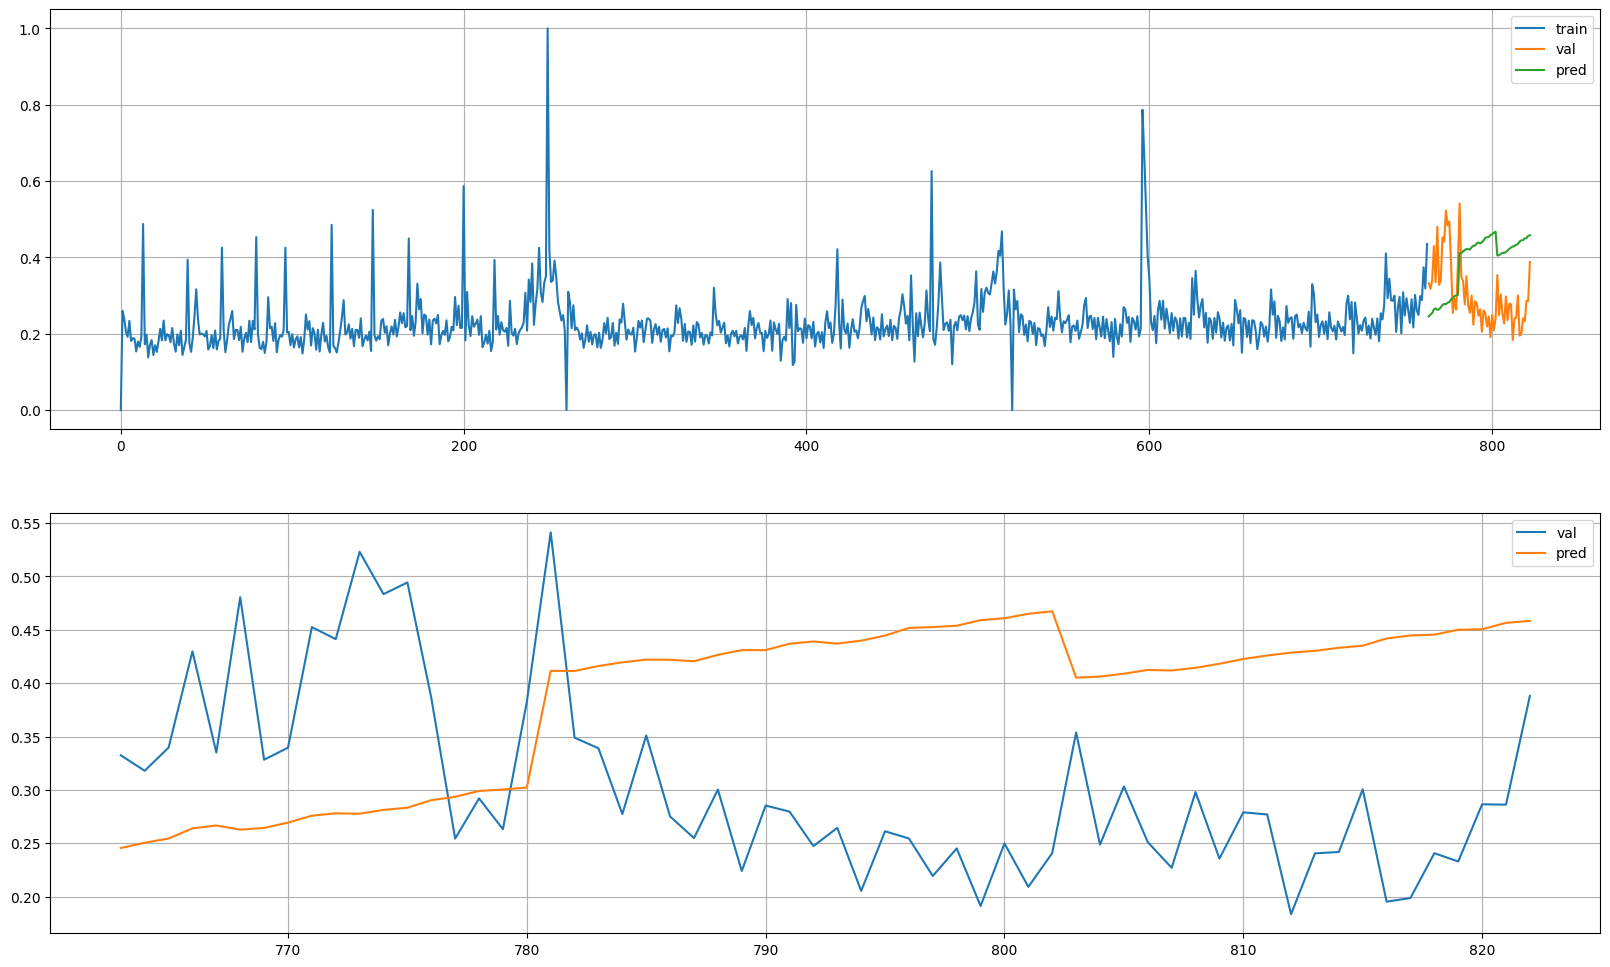

In [205]:
plot_model_result(y_train, y_val, y_pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [206]:
# 필요한 열 선택
features_42 = df_42.drop(['Date', 'target'], axis=1)
targets_42 = df_42['target']

features_42

,Qty,CustomerCount,Year,Month,Day,Day_of_week,Day_of_week_2,isSummer,isWinter
0,76.0,4422,2014,1,2,3,5.0,0,1
1,74.0,4167,2014,1,3,4,6.0,0,1
2,78.0,5341,2014,1,4,5,0.0,0,1
3,88.0,5123,2014,1,5,6,1.0,0,1
4,65.0,3917,2014,1,6,0,2.0,0,1
...,...,...,...,...,...,...,...,...,...
1139,72.0,3834,2017,2,22,2,4.0,0,1
1140,98.0,3955,2017,2,23,3,5.0,0,1
1141,91.0,4549,2017,2,24,4,6.0,0,1
1142,105.0,4619,2017,2,25,5,0.0,0,1


In [207]:
print(features_42.columns)
scaler_42 = MinMaxScaler()
features_scaled_42 = scaler.fit_transform(features_42)

Index(['Qty', 'CustomerCount', 'Year', 'Month', 'Day', 'Day_of_week',
       'Day_of_week_2', 'isSummer', 'isWinter'],
      dtype='object')


In [208]:
# 데이터 분할
X_train_42 = features_scaled_42[:-60]
y_train_42 = targets_42[:-60]
X_val_42 = features_scaled_42[-60:]
y_val_42 = targets_42[-60:]

In [209]:
targets_42.describe()

count    1144.000000
mean      113.250000
std        28.108503
min        45.000000
25%        92.000000
50%       112.000000
75%       132.000000
max       196.000000
Name: target, dtype: float64

### **2) 모델링**

In [210]:
# 모델 구성
model_42 = Sequential()
model_42.add(Dense(1, input_dim=X_train_42.shape[1], activation='relu'))

# 모델 컴파일
model_42.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [211]:
history_42 = model_42.fit(X_train_42, y_train_42, epochs=50, batch_size=10, validation_data=(X_val_42, y_val_42))

Epoch 1/50
109/109 [==============================] - 1s 6ms/step - loss: 13783.1533 - mae: 114.0389 - mape: 99.4684 - val_loss: 7827.8013 - val_mae: 87.2031 - val_mape: 98.8791
Epoch 2/50
109/109 [==============================] - 0s 3ms/step - loss: 13668.6260 - mae: 113.5423 - mape: 99.0117 - val_loss: 7730.1719 - val_mae: 86.6434 - val_mape: 98.2264
Epoch 3/50
109/109 [==============================] - 0s 3ms/step - loss: 13554.2188 - mae: 113.0453 - mape: 98.5555 - val_loss: 7634.5811 - val_mae: 86.0918 - val_mape: 97.5833
Epoch 4/50
109/109 [==============================] - 0s 2ms/step - loss: 13441.8047 - mae: 112.5539 - mape: 98.1043 - val_loss: 7540.8730 - val_mae: 85.5476 - val_mape: 96.9488
Epoch 5/50
109/109 [==============================] - 0s 2ms/step - loss: 13330.6670 - mae: 112.0654 - mape: 97.6545 - val_loss: 7448.3022 - val_mae: 85.0066 - val_mape: 96.3182
Epoch 6/50
109/109 [==============================] - 0s 2ms/step - loss: 13220.3818 - mae: 111.5812 - mape: 9

In [212]:
predictions_42 = model_42.predict(X_val_42).flatten()

# 평가 지표 계산
rmse_42 = np.sqrt(mean_squared_error(y_val_42, predictions_42))
mae_42 = np.mean(np.abs(predictions_42 - y_val_42))
mape_42 = np.mean(np.abs((y_val_42 - predictions_42) / y_val_42)) * 100
r2_42 = r2_score(y_val_42, predictions_42)

print(f'RMSE: {rmse_42}')
print(f'MAE: {mae_42}')
print(f'MAPE: {mape_42}')
print(f'R2 Score: {r2_42}')

2/2 [==============================] - 0s 6ms/step
RMSE: 63.13802337387802
MAE: 61.39447848002116
MAPE: 68.79484752094712
R2 Score: -16.332719769676082


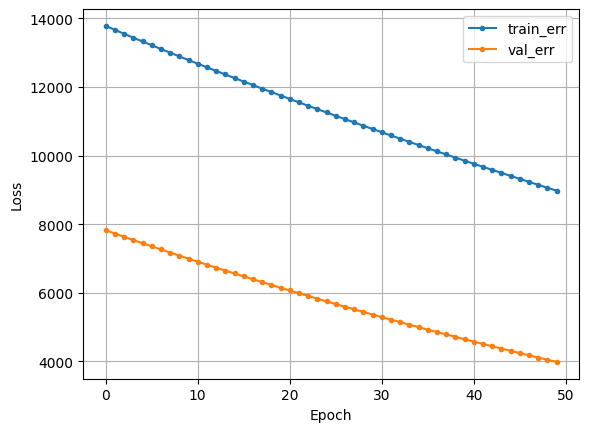

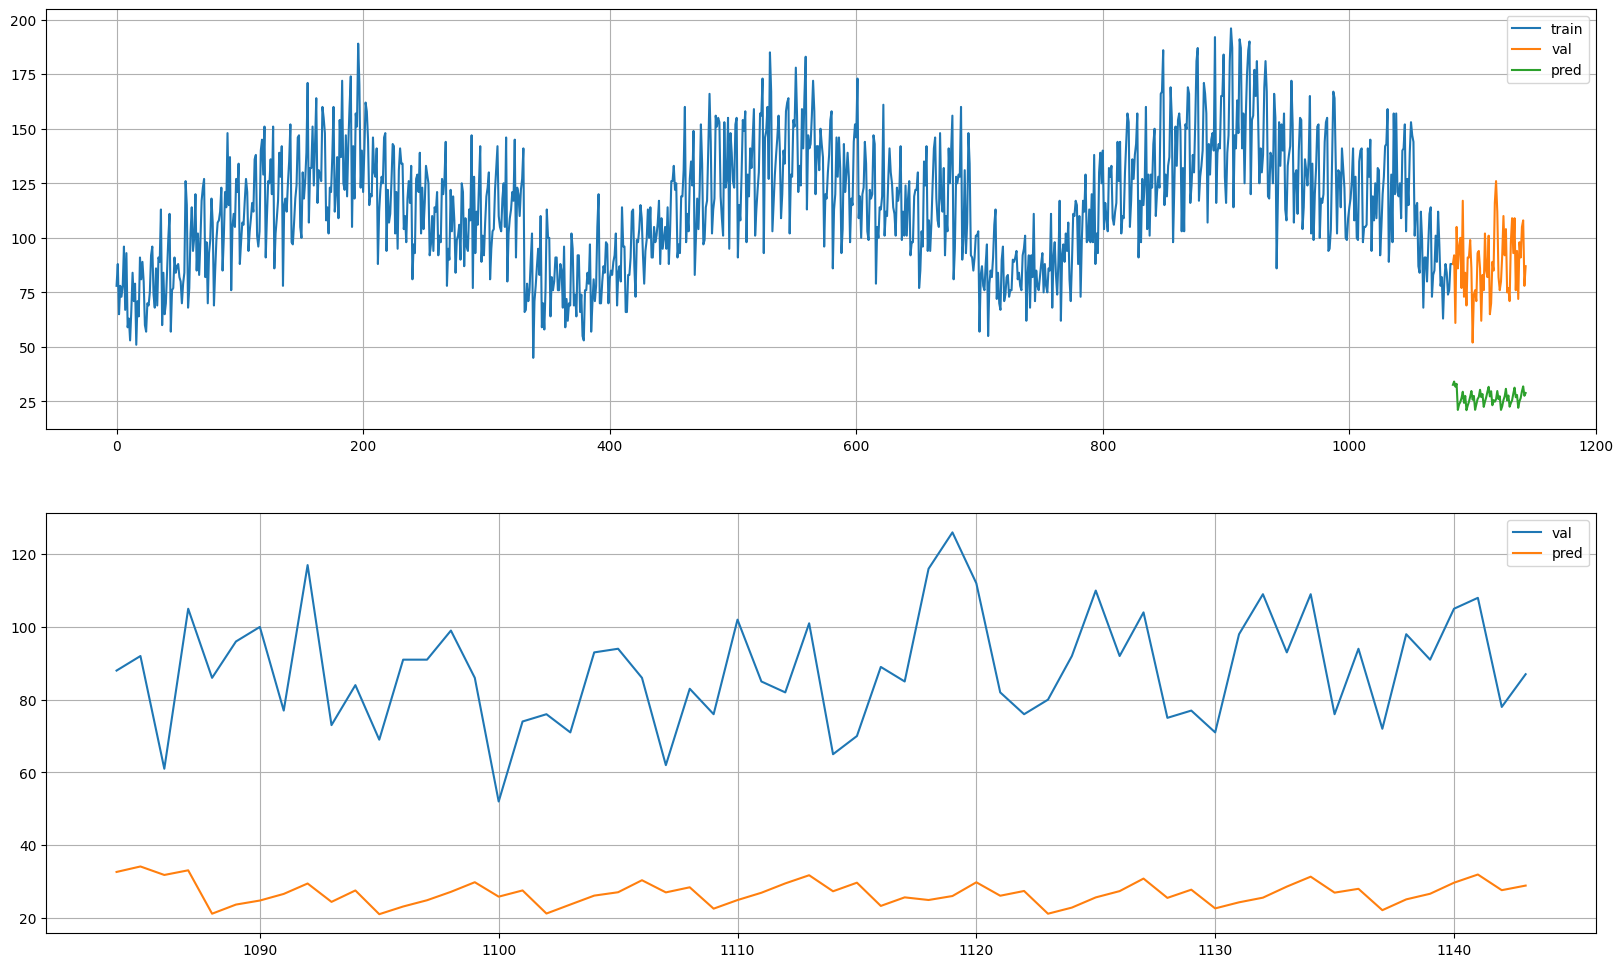

In [213]:
dl_history_plot(history_42.history)
plot_model_result(y_train_42, y_val_42, predictions_42)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [214]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [234]:
def temporalize_12(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x[i:i+timesteps, :-1])
        output_y.append(y[i+timesteps-1, -1])
    return np.array(output_X), np.array(output_y)

In [215]:
def temporalize_42(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x[i:i+timesteps])
        output_y.append(y[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [216]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [217]:
x2, y2 = temporalize(x, y, 7)

In [218]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = 60, shuffle = False)

In [219]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s2 = scale(x_train, scaler)
x_val_s2 = scale(x_val, scaler)

In [220]:
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.reshape(-1,1))

* **모델링**

In [223]:
n_features = x_train_s2.shape[2]

clear_session()

model_LSTM_3 = Sequential([LSTM(100, input_shape = (7, n_features), activation='relu'),
                     Dropout(0.2),
                     Dense(30, activation='relu'),
                     Dense(5, activation='relu'),
                    Dense(1)])

model_LSTM_3.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

In [224]:
hist = model_LSTM_3.fit(x_train_s2, y_train_s2, epochs=30, validation_split=.2).history

Epoch 1/30
28/28 [==============================] - 2s 20ms/step - loss: 0.0373 - val_loss: 0.0134
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.0131 - val_loss: 0.0204
Epoch 3/30
28/28 [==============================] - 0s 10ms/step - loss: 0.0131 - val_loss: 0.0057
Epoch 4/30
28/28 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 5/30
28/28 [==============================] - 0s 10ms/step - loss: 0.0085 - val_loss: 0.0054
Epoch 6/30
28/28 [==============================] - 0s 10ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 7/30
28/28 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0058
Epoch 8/30
28/28 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 9/30
28/28 [==============================] - 0s 15ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 10/30
28/28 [==============================] - 0s 15ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 11/3

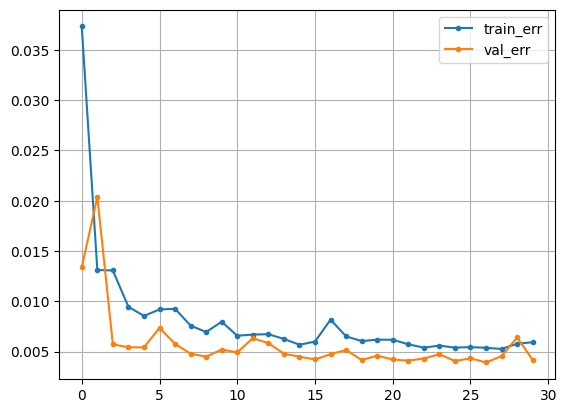

In [225]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [226]:
pred = model_LSTM_3.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 9ms/step


In [227]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 2000.269775390625
MAPE: 1.0167948549129852e+18
R2  : 0.3532503942731108


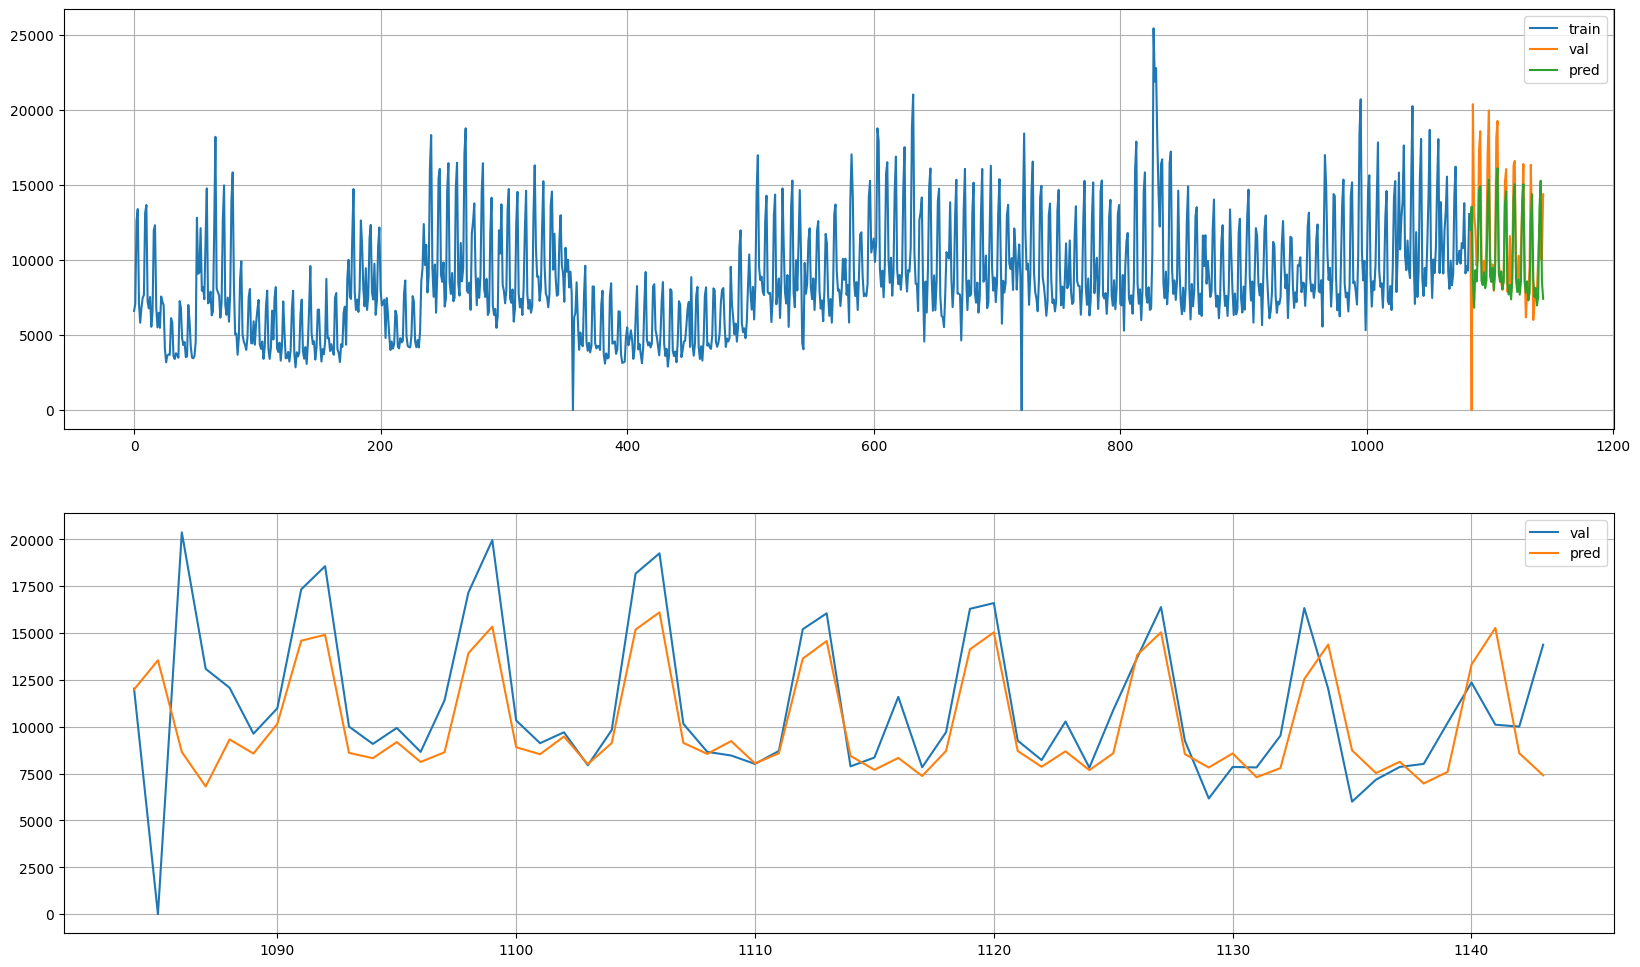

In [228]:
plot_model_result(y_train, y_val, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [235]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D, MaxPooling1D

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_12_season_oil_final[['WTI_Price', 'Year', 'Month', 'Day', 'Autumn', 'Spring', 'Summer', 'Winter', 'Qty']])

train_size = df_12_season_oil_final.shape[0] - 60
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:]

timesteps = 7
X_train, y_train = temporalize_12(train_data, train_data, timesteps)
X_val, y_val = temporalize_12(val_data, val_data, timesteps)

* **모델링**

In [236]:
# LSTM 모델 생성 함수
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    return model

In [237]:
lstm_model = create_lstm_model(X_train.shape[1:])
lstm_model.compile(optimizer='adam', loss='mse')
history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0)

In [238]:
lstm_y_pred = lstm_model.predict(X_val)

mse = mean_squared_error(y_val, lstm_y_pred)
mape = np.mean(np.abs((y_val - lstm_y_pred) / y_val)) * 100
r2 = r2_score(y_val, lstm_y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R2 Score:", r2)

2/2 [==============================] - 1s 6ms/step
Mean Squared Error (MSE): 0.008302907551863803
Mean Absolute Percentage Error (MAPE): 23.09645116930027
R2 Score: -0.16123676759605576


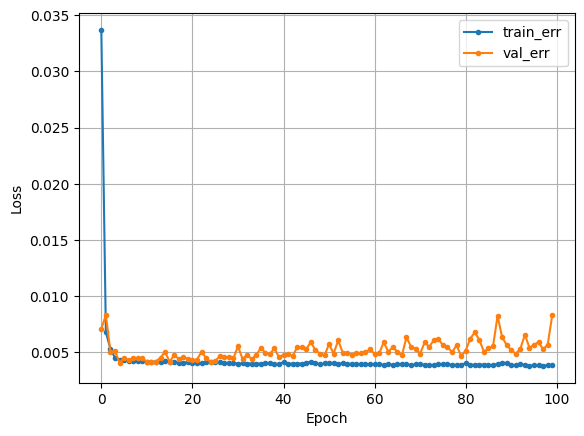

In [239]:
dl_history_plot(history_lstm.history)

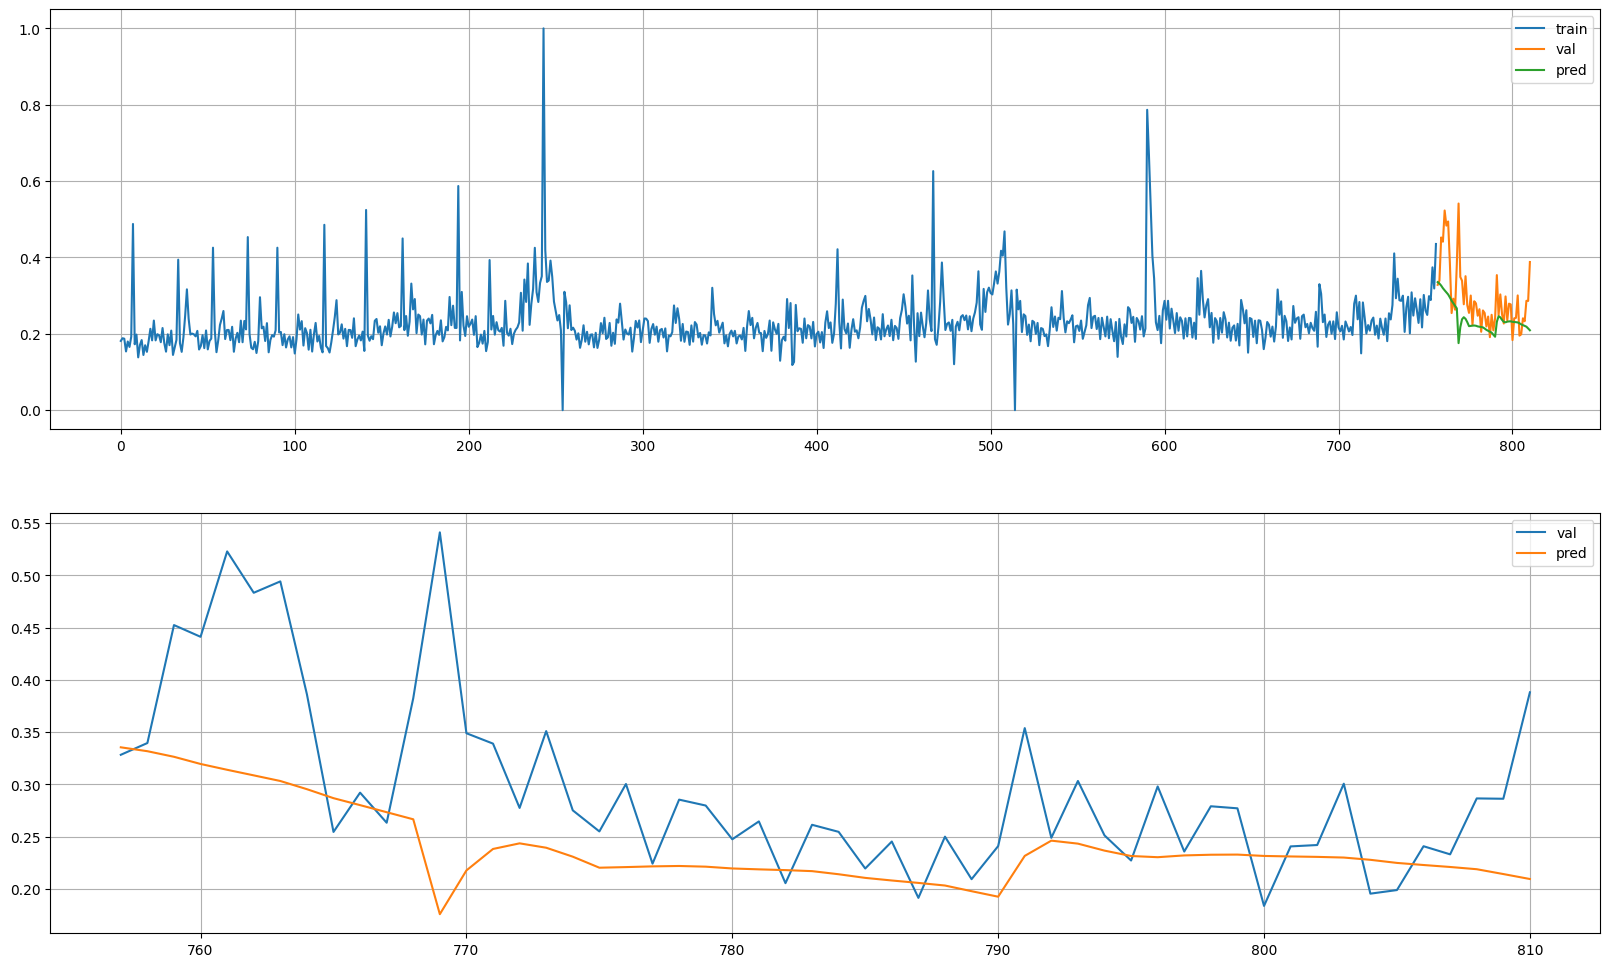

In [240]:
plot_model_result(y_train, y_val, lstm_y_pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [241]:
timesteps_42 = 7
X_42, y_42 = temporalize_42(features_scaled_42, targets_42, timesteps_42)
t_x_train_42 = X_42[:-60]
t_y_train_42 = y_42[:-60]
t_x_val_42 = X_42[-60:]
t_y_val_42 = y_42[-60:]

* **모델링**

In [242]:
model_lstm_42 = Sequential()
model_lstm_42.add(LSTM(50, input_shape=(t_x_train_42.shape[1], t_x_train_42.shape[2])))  # 50개의 노드를 가진 LSTM 레이어
model_lstm_42.add(Dense(1))  # 출력 레이어
model_lstm_42.compile(optimizer='adam', loss='mse')

# 모델 요약
model_lstm_42.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12000     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12051 (47.07 KB)
Trainable params: 12051 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [243]:
history_lstm_42 = model_lstm_42.fit(t_x_train_42, t_y_train_42, epochs=10, validation_split=0.2, verbose=1, validation_data=(t_x_val_42, t_y_val_42))

Epoch 1/10
34/34 [==============================] - 3s 21ms/step - loss: 13649.9609 - val_loss: 7200.2124
Epoch 2/10
34/34 [==============================] - 0s 7ms/step - loss: 12332.3496 - val_loss: 6428.8115
Epoch 3/10
34/34 [==============================] - 0s 7ms/step - loss: 11630.0088 - val_loss: 6049.7427
Epoch 4/10
34/34 [==============================] - 0s 6ms/step - loss: 11168.5801 - val_loss: 5734.4814
Epoch 5/10
34/34 [==============================] - 0s 6ms/step - loss: 10760.3896 - val_loss: 5448.5801
Epoch 6/10
34/34 [==============================] - 0s 7ms/step - loss: 10381.5723 - val_loss: 5181.4995
Epoch 7/10
34/34 [==============================] - 0s 6ms/step - loss: 10022.8936 - val_loss: 4929.3350
Epoch 8/10
34/34 [==============================] - 0s 7ms/step - loss: 9680.7393 - val_loss: 4688.6782
Epoch 9/10
34/34 [==============================] - 0s 6ms/step - loss: 9352.0303 - val_loss: 4459.2520
Epoch 10/10
34/34 [==============================] - 0s 

In [244]:
predictions_lstm_42 = model_lstm_42.predict(t_x_val_42)
rmse_lstm_42 = np.sqrt(mean_squared_error(t_y_val_42, predictions_lstm_42))
mae_lstm_42 = np.mean(np.abs(predictions_lstm_42 - t_y_val_42))
mape_lstm_42 = np.mean(np.abs((t_y_val_42 - predictions_lstm_42) / t_y_val_42)) * 100
r2_lstm_42 = r2_score(t_y_val_42, predictions_lstm_42)

print("LSTM RMSE:", rmse_lstm_42)
print("LSTM MAE:", mae_lstm_42)
print("LSTM MAPE:", mape_lstm_42)
print("LSTM R2 Score:", r2_lstm_42)

2/2 [==============================] - 0s 9ms/step
LSTM RMSE: 65.11208641153048
LSTM MAE: 63.32149918874105
LSTM MAPE: 70.90546294940998
LSTM R2 Score: -17.43350733439786


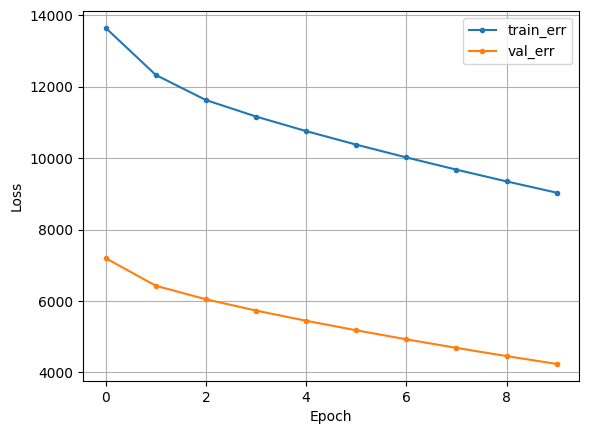

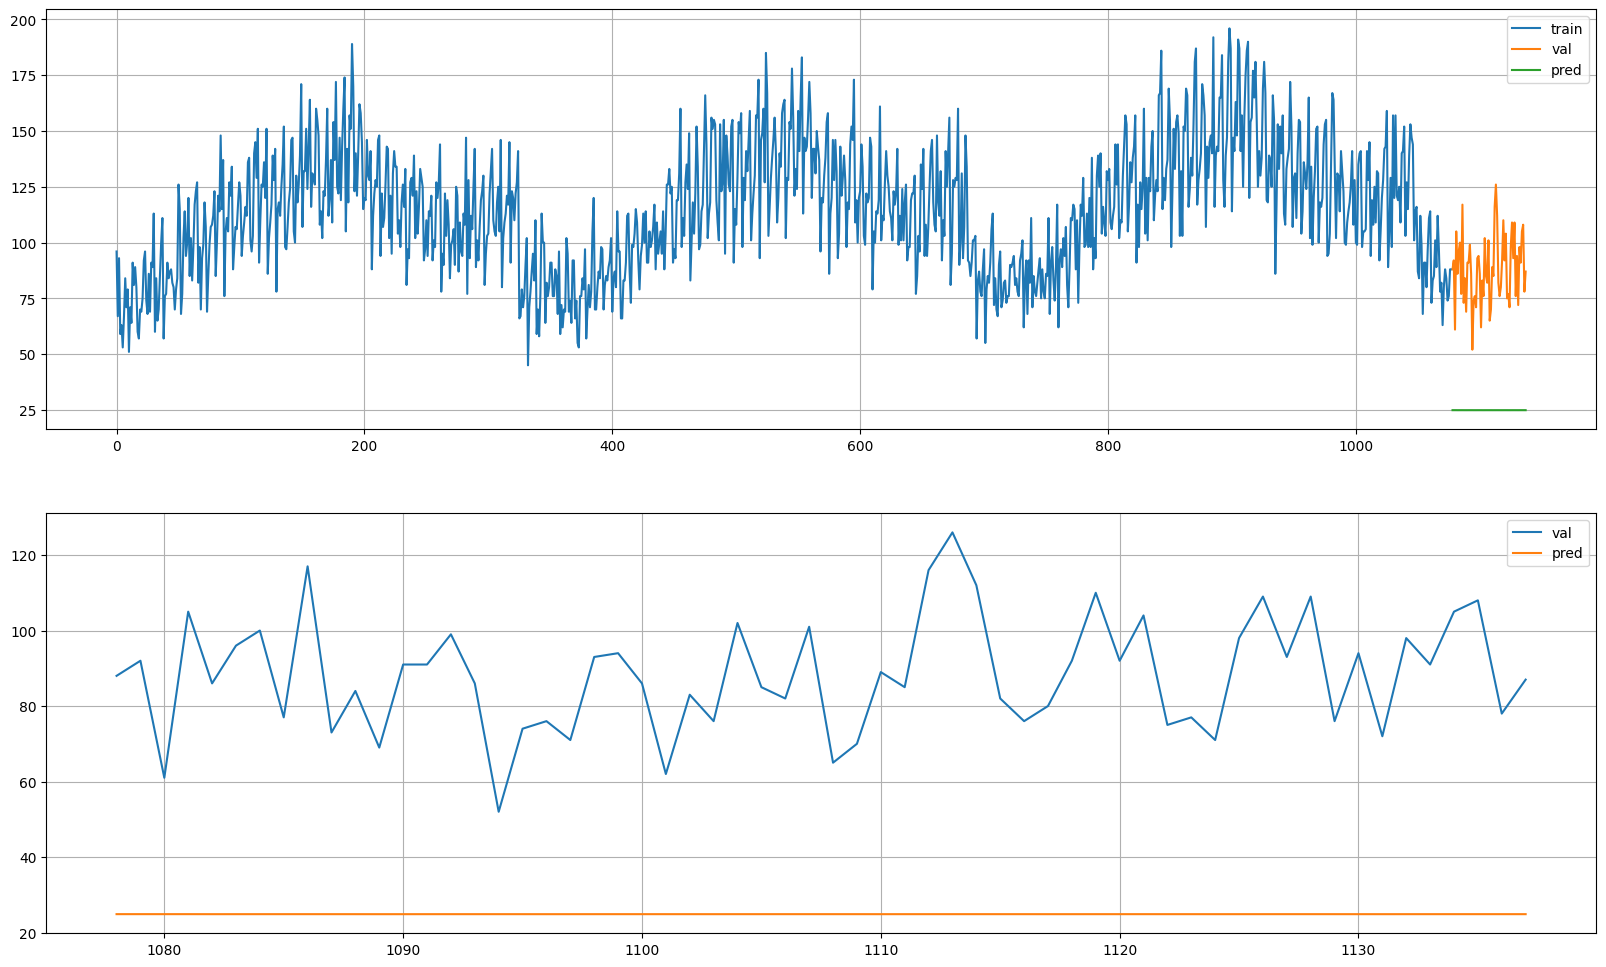

In [245]:
dl_history_plot(history_lstm_42.history)
plot_model_result(t_y_train_42, t_y_val_42, predictions_lstm_42)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [251]:
x2, y2 = temporalize(x, y, 7)
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = 60, shuffle = False)
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))
# 3차원 데이터에 스테일러 적용
x_train_s2 = scale(x_train, scaler)
x_val_s2 = scale(x_val, scaler)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.reshape(-1,1))

In [252]:
n_features = x_train.shape[2]

clear_session()

model_CNN_3 = Sequential([Conv1D(32, 5, input_shape = (7, n_features), activation='relu', padding = 'same'),
                    Conv1D(32, 5, activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(30, activation='relu'),
                    Dense(1)])

model_CNN_3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

In [253]:
hist = model_CNN_3.fit(x_train_s2, y_train_s2, epochs=30, validation_split=.2).history

Epoch 1/30
28/28 [==============================] - 1s 9ms/step - loss: 0.0565 - val_loss: 0.0062
Epoch 2/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0060
Epoch 3/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 4/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 5/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 6/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 7/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 8/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 9/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 10/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 11/30
28/28 [

* **모델링**

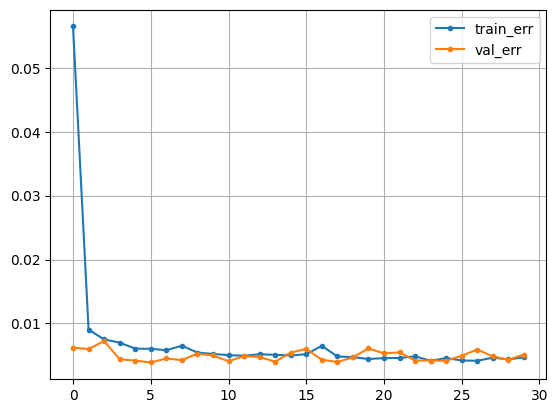

In [254]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [255]:
pred = model_CNN_3.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 5ms/step


In [256]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 2031.2829182942708
MAPE: 1.1628391727901617e+18
R2  : 0.33251434521469414


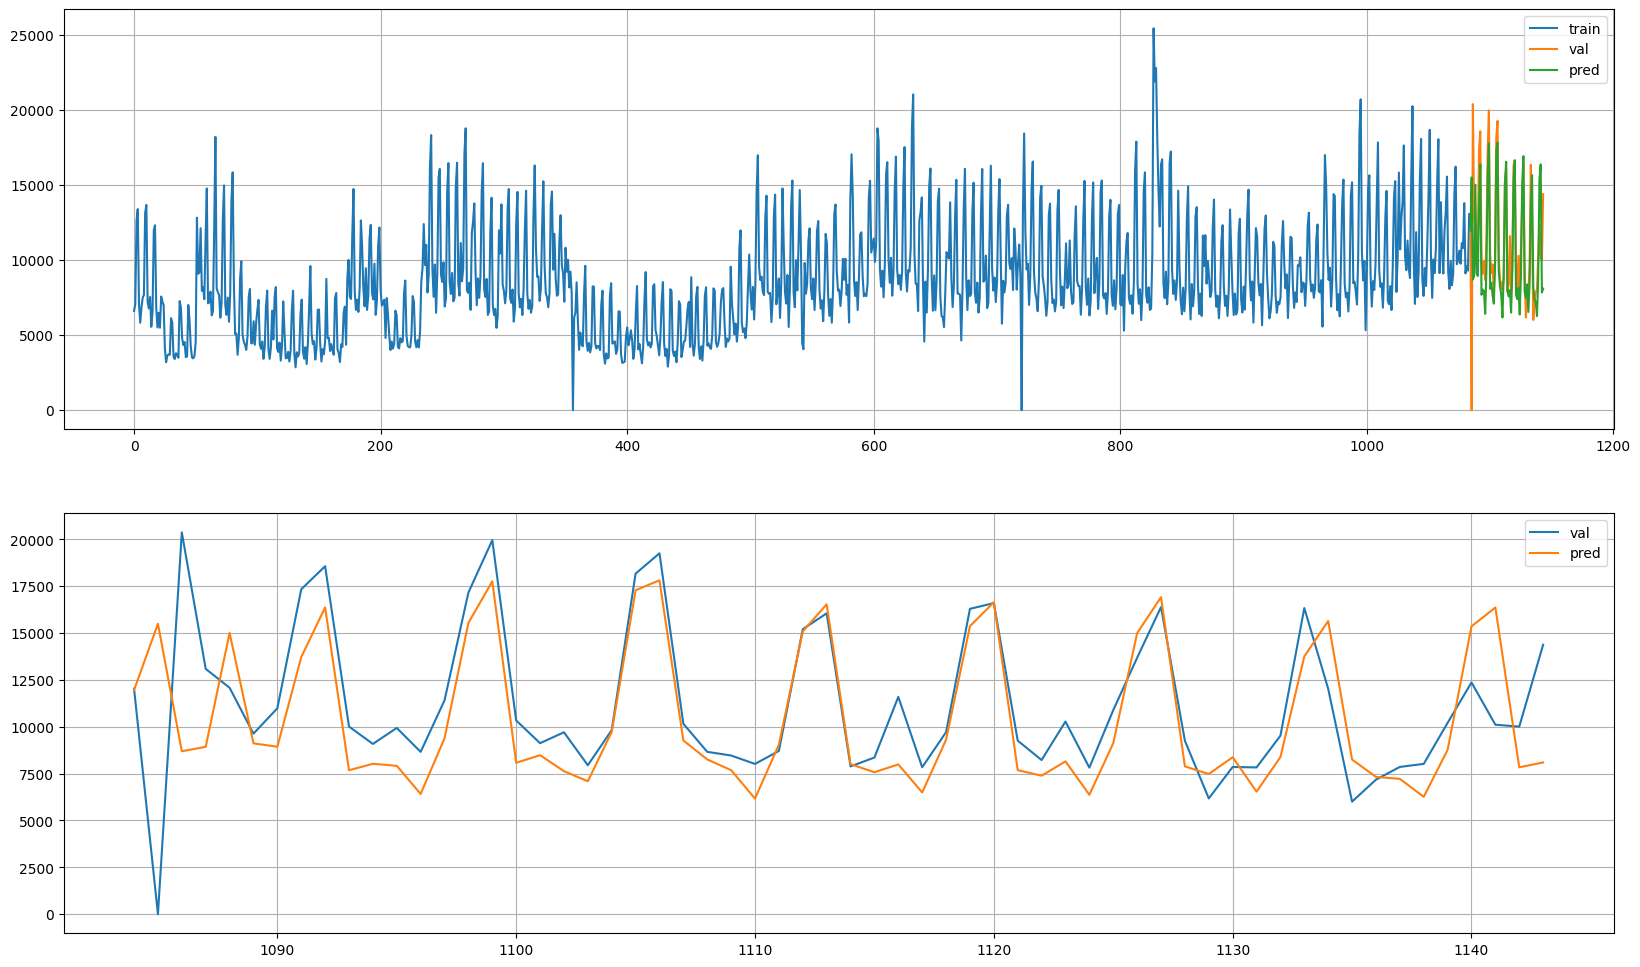

In [257]:
plot_model_result(y_train, y_val, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [258]:
# CNN 모델 생성 함수
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [263]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_12_season_oil_final[['WTI_Price', 'Year', 'Month', 'Day', 'Autumn', 'Spring', 'Summer', 'Winter', 'Qty']])
train_size = df_12_season_oil_final.shape[0] - 60
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:]
timesteps = 7
X_train, y_train = temporalize_12(train_data, train_data, timesteps)
X_val, y_val = temporalize_12(val_data, val_data, timesteps)

* **모델링**

In [264]:
# CNN 모델 생성 및 학습
cnn_model = create_cnn_model(X_train.shape[1:])
cnn_model.compile(optimizer='adam', loss='mse')
history_cnn = cnn_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0)

In [265]:
cnn_y_pred = cnn_model.predict(X_val)

mse = mean_squared_error(y_val, cnn_y_pred)
mape = np.mean(np.abs((y_val - cnn_y_pred) / y_val)) * 100
r2 = r2_score(y_val, cnn_y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R2 Score:", r2)

2/2 [==============================] - 0s 6ms/step
Mean Squared Error (MSE): 0.005799030288716108
Mean Absolute Percentage Error (MAPE): 22.490974404163484
R2 Score: 0.18895312929882213


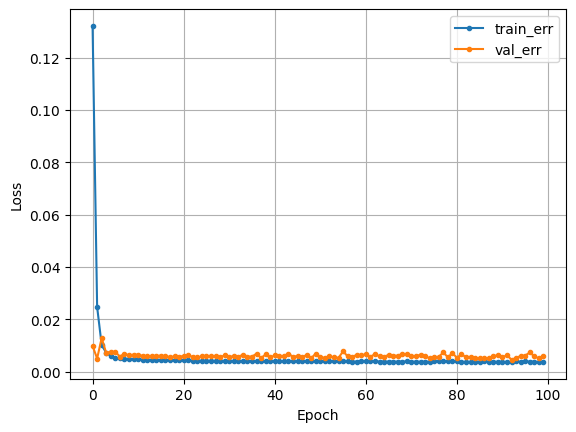

In [266]:
dl_history_plot(history_cnn.history)

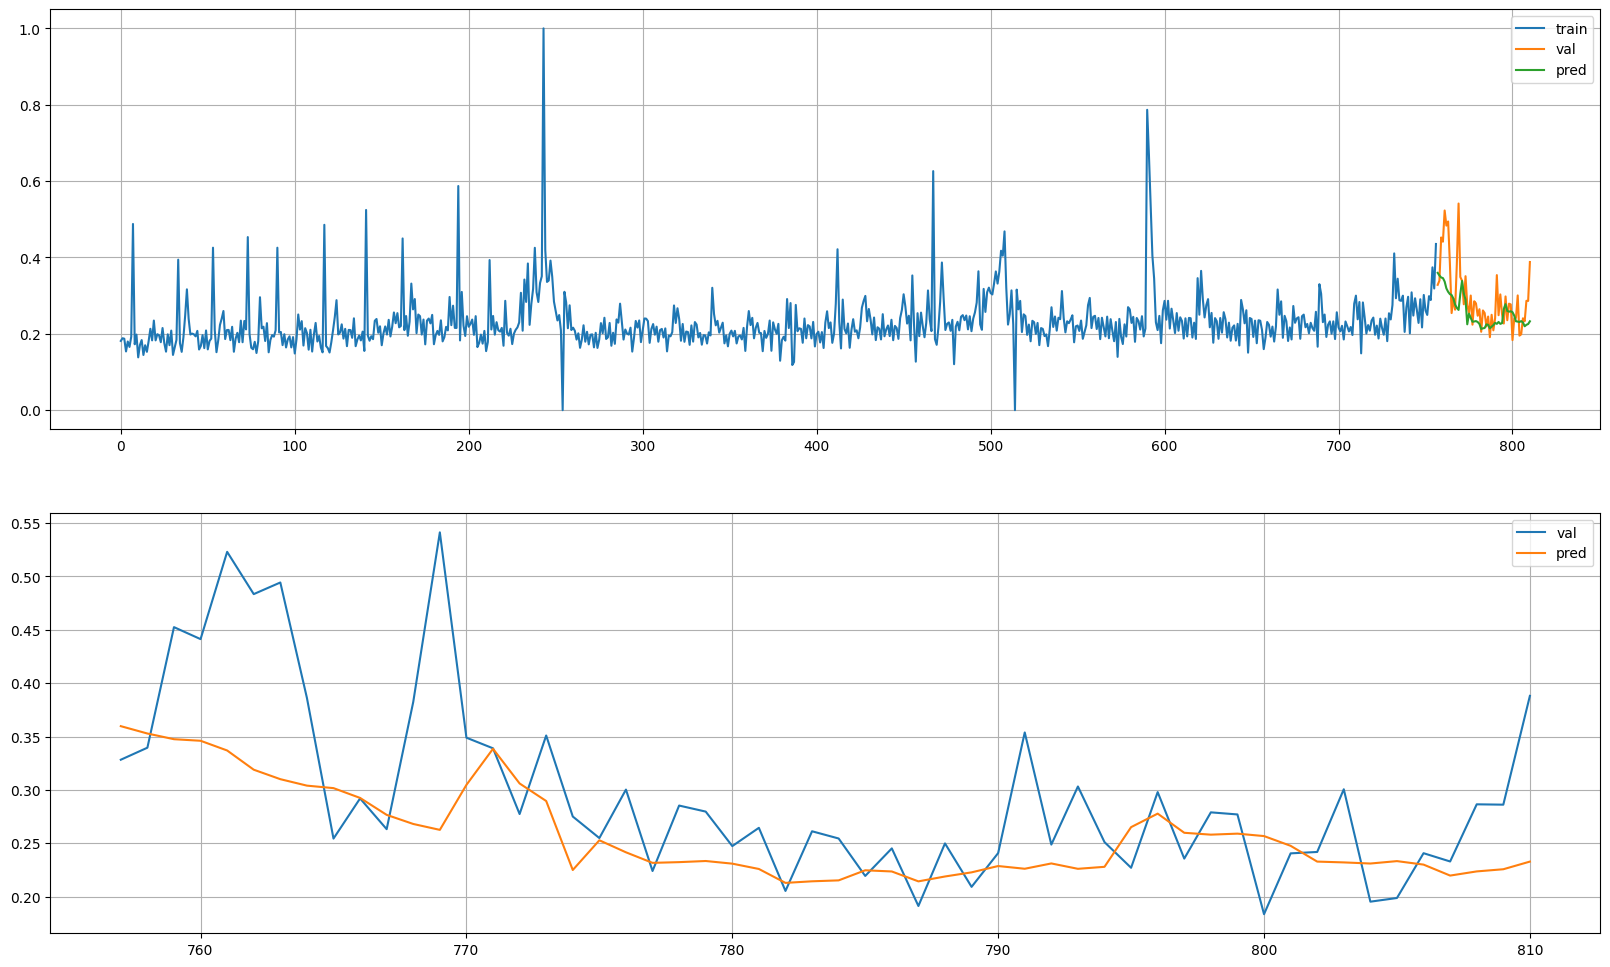

In [267]:
plot_model_result(y_train, y_val, cnn_y_pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

In [268]:
# CNN 모델
model_cnn_42 = Sequential()
model_cnn_42.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(t_x_train_42.shape[1], t_x_train_42.shape[2])))
model_cnn_42.add(Flatten())
model_cnn_42.add(Dense(50, activation='relu'))
model_cnn_42.add(Dense(1))
model_cnn_42.compile(optimizer='adam', loss='mse')

# 모델 요약
model_cnn_42.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 6, 64)             1216      
                                                                 
 flatten_4 (Flatten)         (None, 384)               0         
                                                                 
 dense_5 (Dense)             (None, 50)                19250     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20517 (80.14 KB)
Trainable params: 20517 (80.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [269]:
history_cnn_42 = model_cnn_42.fit(t_x_train_42, t_y_train_42, epochs=10, validation_split=0.2, verbose=1, validation_data=(t_x_val_42, t_y_val_42))

Epoch 1/10
34/34 [==============================] - 1s 8ms/step - loss: 12604.5508 - val_loss: 4691.8887
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 4832.7764 - val_loss: 1171.1893
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 845.8167 - val_loss: 751.1915
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 655.3472 - val_loss: 707.3200
Epoch 5/10
34/34 [==============================] - 0s 4ms/step - loss: 586.5089 - val_loss: 449.3881
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 538.2387 - val_loss: 386.6713
Epoch 7/10
34/34 [==============================] - 0s 4ms/step - loss: 493.2263 - val_loss: 349.4088
Epoch 8/10
34/34 [==============================] - 0s 4ms/step - loss: 447.8691 - val_loss: 360.8372
Epoch 9/10
34/34 [==============================] - 0s 6ms/step - loss: 410.7394 - val_loss: 297.1552
Epoch 10/10
34/34 [==============================] - 0s 6ms/step - loss: 370.

In [270]:
predictions_cnn_42 = model_cnn_42.predict(t_x_val_42)
rmse_cnn_42 = np.sqrt(mean_squared_error(t_y_val_42, predictions_cnn_42))
mae_cnn_42 = np.mean(np.abs(predictions_cnn_42 - t_y_val_42))
mape_cnn_42 = np.mean(np.abs((t_y_val_42 - predictions_cnn_42) / t_y_val_42)) * 100
r2_cnn_42 = r2_score(t_y_val_42, predictions_cnn_42)

print("CNN RMSE:", rmse_cnn_42)
print("CNN MAE:", mae_cnn_42)
print("CNN MAPE:", mape_cnn_42)
print("CNN R2 Score:", r2_cnn_42)

2/2 [==============================] - 0s 6ms/step
CNN RMSE: 16.235070581997007
CNN MAE: 14.96653034210205
CNN MAPE: 19.013134218675948
CNN R2 Score: -0.14602242153000633


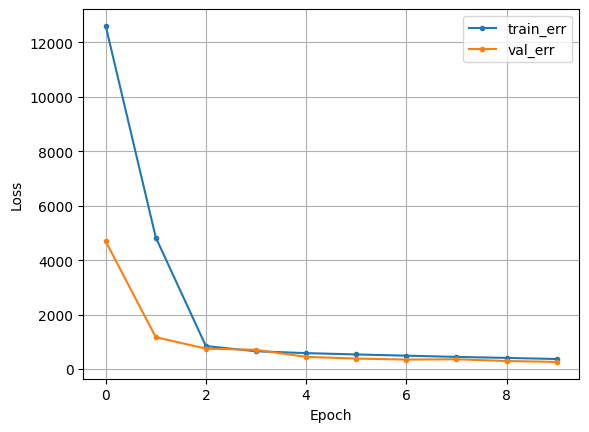

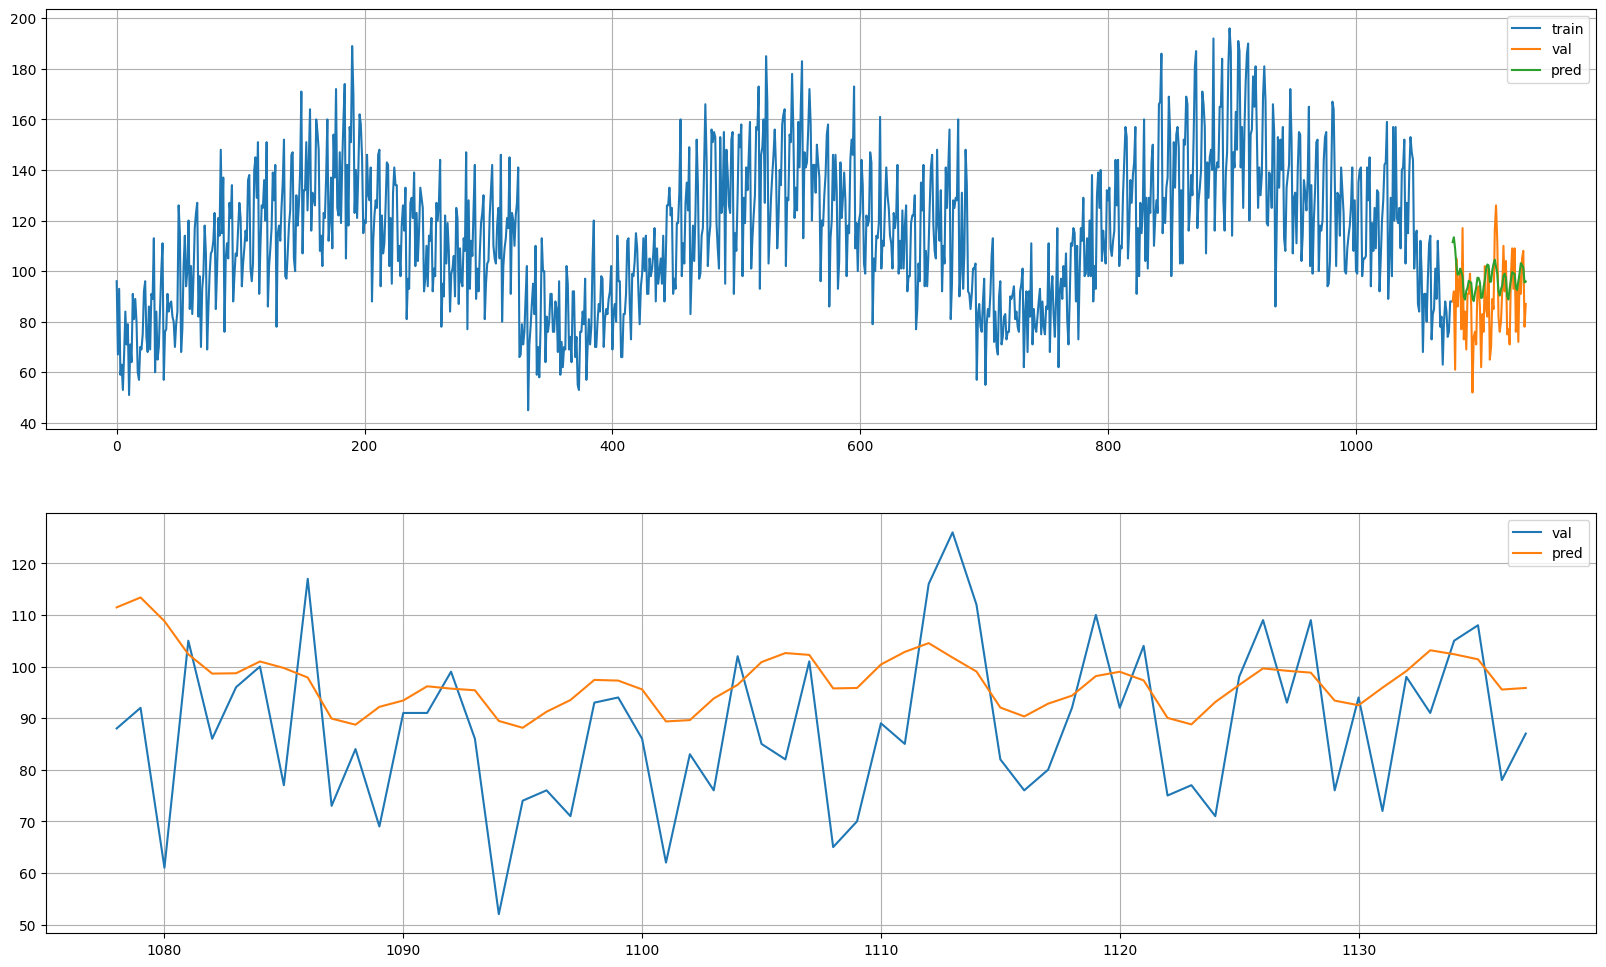

In [271]:
dl_history_plot(history_cnn_42.history)
plot_model_result(t_y_train_42, t_y_val_42, predictions_cnn_42)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [272]:
joblib.dump(df_3, 'df_3.pkl')
joblib.dump(df_12, 'df_12.pkl')
joblib.dump(df_42, 'df_42.pkl')

['df_42.pkl']